<a href="https://colab.research.google.com/github/feast-dev/feast-fraud-tutorial/blob/master/Fraud_Detection_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Throughout this tutorial, we’ll walk through the creation of a production-ready fraud prediction system, end to end. We will be predicting whether a transaction made by a given user will be fraudulent. This prediction will be made in real-time as the user makes the transaction, so we need to be able to generate a prediction at low latency.

Our system will perform the following workflows:
- Computing and backfilling feature data from raw data
- Building point-in-time correct training datasets from feature data and training a model
- Making online predictions from feature data

Here's a high-level picture of our system architecture:




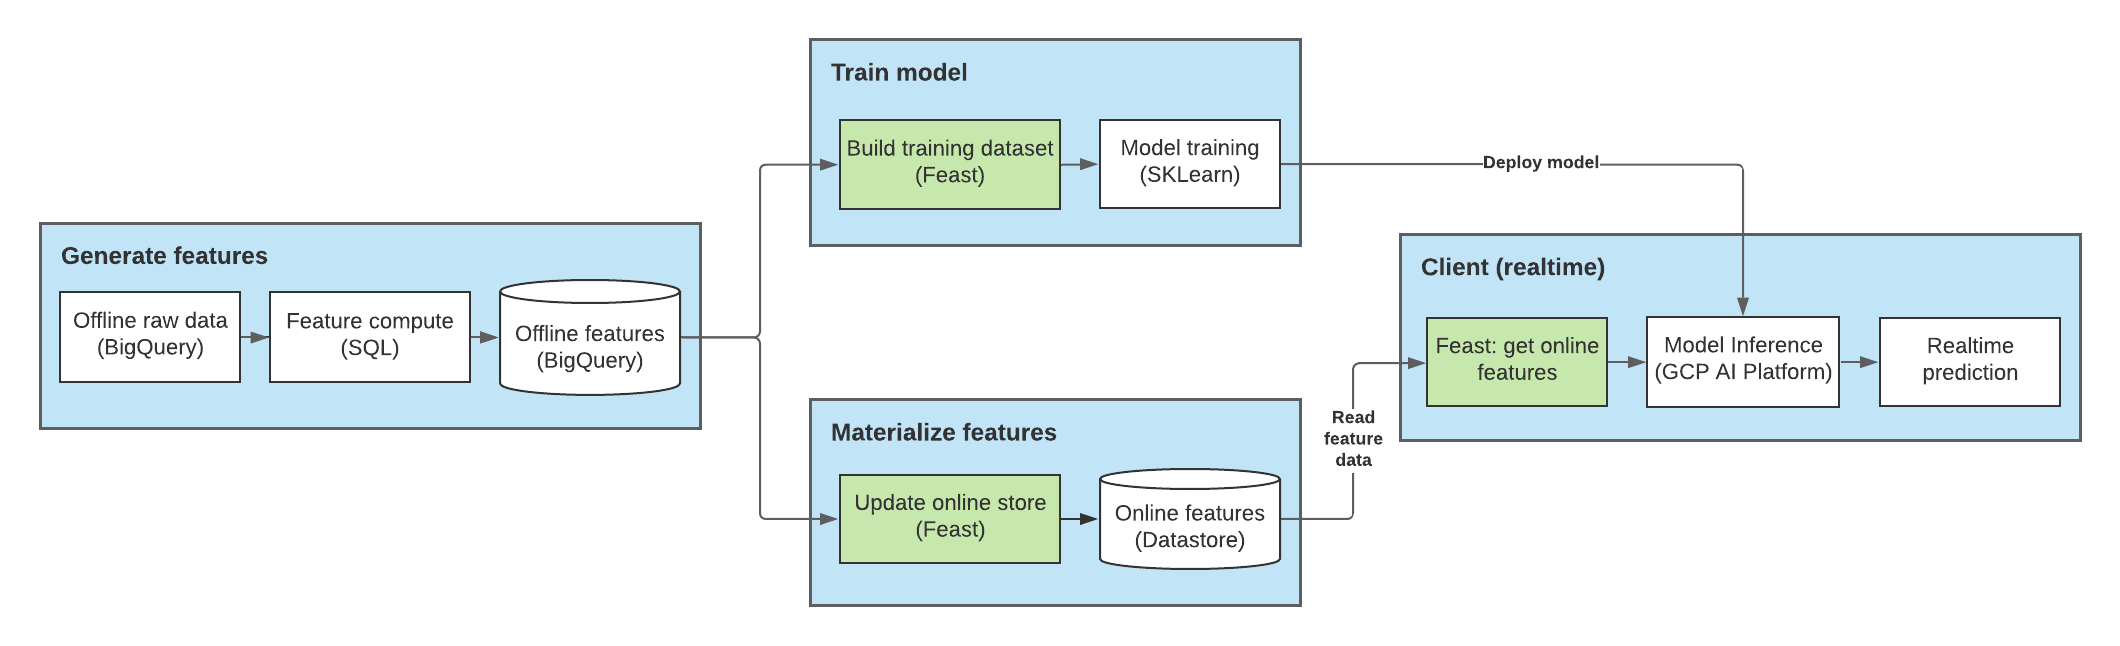

Since Feast is only a component of this system, we'll be creating our system using a stack of other ML / data tools. Our stack will include different tools based on the environment. On GCP, our stack will include the following:

- Our raw data will be stored using Bigquery.
- Our features will be computed using Bigquery SQL.
- Our offline feature store will be Bigquery.
- Our online feature store will be Datastore.
- Our model framework will be SKLearn.
- Our model endpoint will be hosted on GCP AI Platform.

# Installation and set up

### Install Feast

Feast can be installed using pip. This installation includes a Python package as well as a CLI.

Feast contains some packages which conflict with the default versions installed in Colab. **After running this cell, restart the runtime to continue** (Runtime > Restart runtime.)


In [ ]:
# Restart the runtime after executing this cell!

!pip install feast['gcp']
!feast version

Feast SDK Version: "feast 0.11.0"


## Create a project

1. [Create a new project](https://console.cloud.google.com/cloud-resource-manager)
2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)
3. Enable the following APIs:
    1. [Cloud Firestore](https://console.cloud.google.com/firestore/welcome) (be sure to choose **Datastore Mode**)
    2. [AI Platform Models](https://console.cloud.google.com/ai-platform/ml-enable-api/models)
    3. [Cloud Scheduler](https://console.cloud.google.com/apis/library/cloudscheduler.googleapis.com?q=cloud&id=1d54d828-14ed-4976-959b-3b18cca9e859)
    4. [Cloud Build](https://console.cloud.google.com/apis/library/cloudbuild.googleapis.com?q=cloud&id=9472915e-c82c-4bef-8a6a-34c81e5aebcc)
    5. [Cloud Functions](https://console.cloud.google.com/apis/library/cloudfunctions.googleapis.com?q=cloud%20functions&id=2174da14-0e34-49ed-9267-e258674e95da)

## Authenticate into GCP

Feast spins up infrastructure on GCP using the credentials in our environment. Run the following cell to log into GCP:

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Set configurations

Set the following configuration, which we'll be using throughout the tutorial:

- PROJECT_ID: Your project.
- BUCKET_NAME: The name of a bucket which will be used to store the feature store registry and model artifacts.
- BIGQUERY_DATASET_NAME: The name of a dataset which will be used to create tables containing features.
- AI_PLATFORM_MODEL_NAME: The name of a model name which will be created in AI Platform.

In [ ]:
PROJECT_ID= "YOUR_PROJECT_ID" #@param {type:"string"}
BUCKET_NAME= "YOUR_BUCKET_NAME" #@param {type:"string"} custom
BIGQUERY_DATASET_NAME="YOUR_TUTORIAL_NAME" #@param {type:"string"} custom
AI_PLATFORM_MODEL_NAME="feast_fraud_<YOUR_NAME>_model" #@param {type:"string"

! gcloud config set project $PROJECT_ID
%env GOOGLE_CLOUD_PROJECT=$PROJECT_ID
!echo project_id = $PROJECT_ID > ~/.bigqueryrc

Updated property [core/project].
env: GOOGLE_CLOUD_PROJECT=kf-feast


## Create a bucket
**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
# Only run if your bucket doesn't already exist!
! gsutil mb gs://$BUCKET_NAME

Creating gs://jsd_fraud_tutorial_run/...


## Create a BigQuery dataset
**Only if your dataset doesn't already exist**: Run the following cell to create your BigQuery dataset.

In [ ]:
! bq mk $BIGQUERY_DATASET_NAME

Dataset 'kf-feast:feast_fraud_tutorial' successfully created.


## Initialize the feature repository

In Feast, you define your features using configuration stored in a repository. To start, initialize a feature repository.

In [ ]:
! feast init fraud_tutorial -t gcp
%cd fraud_tutorial/
! ls


Creating a new Feast repository in /content/fraud_tutorial.

/content/fraud_tutorial
driver_repo.py	feature_store.yaml  test.py


Next, we'll edit the `feature_store.yaml` file to reference our bucket. Note that the `project` field in this file refers to the Feast concept of a project, not a GCP project.

In [ ]:
feature_store = \
f"""project: fraud_tutorial
registry: gs://{BUCKET_NAME}/registry.db
provider: gcp"""

with open('feature_store.yaml', "w") as feature_store_file:
    feature_store_file.write(feature_store)

# Print our feature_store.yaml
! cat feature_store.yaml

project: fraud_tutorial
registry: gs://jsd_fraud_tutorial_run/registry.db
provider: gcp

Then, we can apply our feature repository:

In [ ]:
! feast apply

Registered entity driver_id
Registered feature view driver_hourly_stats
Deploying infrastructure for driver_hourly_stats


# Creating features

Next, let's make a new feature and register it to the store.

This involves two steps.

- **Using Bigquery**, we generate new feature values using SQL. Feast is used not to generate features, which is done in Python/SQL.
- **Using Feast**, we register our new features in Feast by creating a FeatureView:



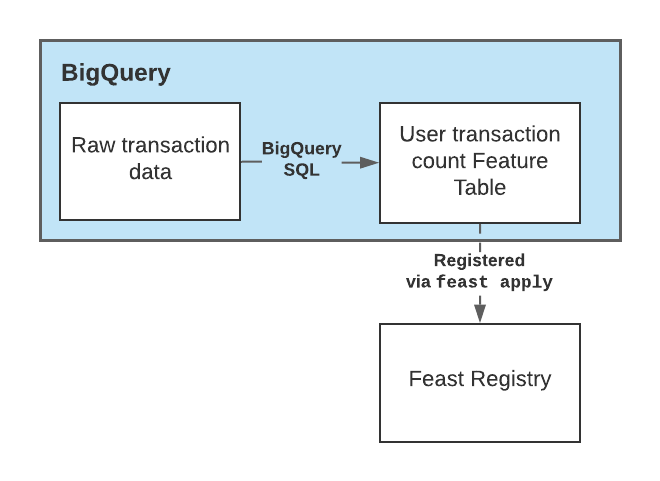

## Preview the raw data

In [ ]:
%%bigquery

select * from feast-oss.fraud_tutorial.transactions limit 1000

Downloading: 100%|██████████| 1000/1000 [00:02<00:00, 334.24rows/s]


,src_account,amount,dest_account,is_fraud,timestamp
0,0001mg,3012.44,ydnwlr,0,2021-07-24 15:39:36.606567+00:00
1,0001mg,4431.82,oijv7z,0,2021-07-21 14:34:33.067750+00:00
2,0001mg,3037.60,a6mrvu,0,2021-07-19 23:38:33.405995+00:00
3,0001mg,6322.63,bmihen,0,2021-07-19 16:33:46.896750+00:00
4,0001mg,9981.82,tk53lu,0,2021-07-17 02:19:05.672327+00:00
...,...,...,...,...,...
995,0e8q8g,8430.40,zkalwn,0,2021-07-11 10:15:51.044902+00:00
996,0efs3l,2089.27,1egwlq,0,2021-07-24 10:57:31.845153+00:00
997,0efs3l,8805.19,xxuqat,0,2021-07-24 07:42:52.053850+00:00
998,0efs3l,1590.20,brg2wu,0,2021-07-23 11:24:19.137748+00:00


## Create a feature table using SQL

Then, run the following cell to generate features. This cell contains two functions:

- `generate_user_count_features` runs a SQL query that counts the amount of transactions users have made as of a given point in time.

- `backfill_features` runs this query multiple times over an interval to backfill features.



In [ ]:
from datetime import datetime, timedelta
from google.cloud import bigquery
import time

def generate_user_count_features(aggregation_end_date):
    table_id  = f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_count_transactions_7d"

    client = bigquery.Client()
    job_config = bigquery.QueryJobConfig(destination=table_id, write_disposition='WRITE_APPEND')

    aggregation_start_date = datetime.now() - timedelta(days=7)

    sql = f"""
    SELECT
        src_account AS user_id,
        COUNT(*) AS transaction_count_7d,
        timestamp'{aggregation_end_date.isoformat()}' AS feature_timestamp
    FROM
        feast-oss.fraud_tutorial.transactions
    WHERE
        timestamp BETWEEN TIMESTAMP('{aggregation_start_date.isoformat()}')
        AND TIMESTAMP('{aggregation_end_date.isoformat()}')
    GROUP BY
        user_id
    """

    query_job = client.query(sql, job_config=job_config)
    query_job.result()
    print(f"Generated features as of {aggregation_end_date.isoformat()}")


def backfill_features(earliest_aggregation_end_date, interval, num_iterations):
    aggregation_end_date = earliest_aggregation_end_date
    for _ in range(num_iterations):
        generate_user_count_features(aggregation_end_date=aggregation_end_date)
        time.sleep(1)
        aggregation_end_date += interval

if __name__ == '__main__':
    backfill_features(
        earliest_aggregation_end_date=datetime.now() - timedelta(days=7),
        interval=timedelta(days=1),
        num_iterations=8
    )


Generated features as of 2021-07-17T22:30:37.626155
Generated features as of 2021-07-18T22:30:37.626155
Generated features as of 2021-07-19T22:30:37.626155
Generated features as of 2021-07-20T22:30:37.626155
Generated features as of 2021-07-21T22:30:37.626155
Generated features as of 2021-07-22T22:30:37.626155
Generated features as of 2021-07-23T22:30:37.626155
Generated features as of 2021-07-24T22:30:37.626155


Then, we can preview our new feature:

In [ ]:
%%bigquery 

select * from feast_fraud_tutorial.user_count_transactions_7d limit 1000

Downloading: 100%|██████████| 1000/1000 [00:03<00:00, 332.34rows/s]


,user_id,transaction_count_7d,feature_timestamp
0,5w71x1,1,2021-07-24 22:30:37.626155+00:00
1,61enp8,1,2021-07-24 22:30:37.626155+00:00
2,798vge,1,2021-07-24 22:30:37.626155+00:00
3,7wm6zr,1,2021-07-24 22:30:37.626155+00:00
4,a9vulj,1,2021-07-24 22:30:37.626155+00:00
...,...,...,...
995,cmkhw3,2,2021-07-24 22:30:37.626155+00:00
996,cuq26f,2,2021-07-24 22:30:37.626155+00:00
997,e5k50u,2,2021-07-24 22:30:37.626155+00:00
998,go8djl,2,2021-07-24 22:30:37.626155+00:00


## Create a new FeatureView

Create a new file, `fraud_features.py`, which contains our new feature definition.

In [ ]:
fraud_features = \
f"""
from datetime import timedelta
from feast import BigQuerySource, FeatureView, Entity, ValueType

# Add an entity for users
user_entity = Entity(
    name="user_id",
    description="A user that has executed a transaction or received a transaction",
    value_type=ValueType.STRING
)

# Add a FeatureView based on our new table
driver_stats_fv = FeatureView(
    name="user_transaction_count_7d",
    entities=["user_id"],
    ttl=timedelta(weeks=1),
    input=BigQuerySource(
        table_ref=f"{PROJECT_ID}.{BIGQUERY_DATASET_NAME}.user_count_transactions_7d",
        event_timestamp_column="feature_timestamp"))

# Add two FeatureViews based on existing tables in BigQuery
user_account_fv = FeatureView(
    name="user_account_features",
    entities=["user_id"],
    ttl=timedelta(weeks=52),
    input=BigQuerySource(
        table_ref=f"feast-oss.fraud_tutorial.user_account_features",
        event_timestamp_column="feature_timestamp"))

user_has_fraudulent_transactions_fv = FeatureView(
    name="user_has_fraudulent_transactions",
    entities=["user_id"],
    ttl=timedelta(weeks=52),
    input=BigQuerySource(
        table_ref=f"feast-oss.fraud_tutorial.user_has_fraudulent_transactions",
        event_timestamp_column="feature_timestamp"))
"""

with open('fraud_features.py', "w") as fraud_features_file:
    fraud_features_file.write(fraud_features)

In [ ]:
# Remove example features
!rm driver_repo.py
# Apply our changes
!feast apply

Registered entity user_id
Deleted feature view driver_hourly_stats from registry
Registered feature view user_transaction_count_7d
Registered feature view user_account_features
Registered feature view user_has_fraudulent_transactions
Deploying infrastructure for user_transaction_count_7d
Deploying infrastructure for user_account_features
Deploying infrastructure for user_has_fraudulent_transactions
Removing infrastructure for driver_hourly_stats


# Training and deploying a model

Next, we'll train a model using our features:

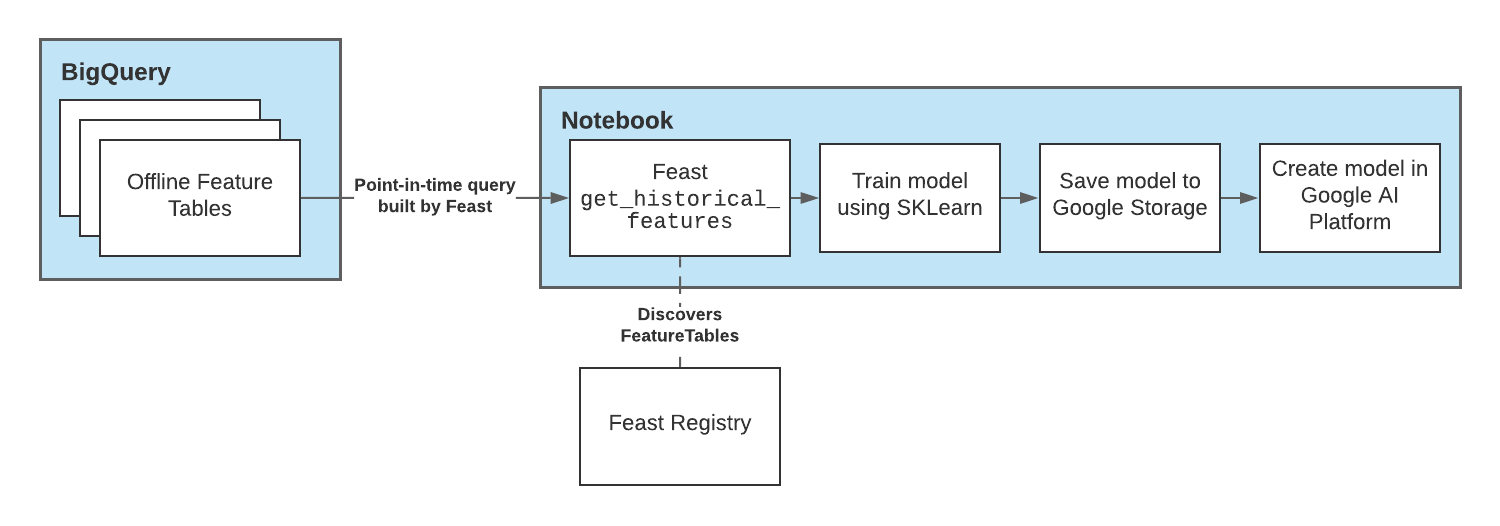

## Fetching training data

Now that our feature is registered in Feast, we can use Feast to generate a training dataset. To do this, we need an entity dataframe, alongside the list of features we want:

In [ ]:
from datetime import datetime, timedelta
from feast import FeatureStore

# Initialize a FeatureStore with our current repository's configurations
store = FeatureStore(repo_path=".")

# Get training data
now = datetime.now()
two_days_ago = datetime.now() - timedelta(days=2)

training_data = store.get_historical_features(
    entity_df=f"""
    select 
        src_account as user_id,
        timestamp,
        is_fraud
    from
        feast-oss.fraud_tutorial.transactions
    where
        timestamp between timestamp('{two_days_ago.isoformat()}') 
        and timestamp('{now.isoformat()}')""",
    feature_refs=[
        "user_transaction_count_7d:transaction_count_7d",
        "user_account_features:credit_score",
        "user_account_features:account_age_days",
        "user_account_features:user_has_2fa_installed",
        "user_has_fraudulent_transactions:user_has_fraudulent_transactions_7d"
    ]
).to_df()

training_data.head()


Using timestamp as the event timestamp. To specify a column explicitly, please name it event_timestamp.


,user_id,timestamp,is_fraud,user_transaction_count_7d__transaction_count_7d,user_account_features__credit_score,user_account_features__account_age_days,user_account_features__user_has_2fa_installed,user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d
0,0001mg,2021-07-24 15:39:36.606567+00:00,0,3.0,704,499,0,0.0
1,000q95,2021-07-24 12:44:24.995791+00:00,0,4.0,737,236,1,1.0
2,000q95,2021-07-22 23:23:04.802760+00:00,0,2.0,737,236,1,1.0
3,000q95,2021-07-24 20:08:02.911410+00:00,0,4.0,737,236,1,1.0
4,000q95,2021-07-22 23:26:32.789396+00:00,0,2.0,737,236,1,1.0


## Training a model

Now, we can use our features to train a model:

In [ ]:
from sklearn.linear_model import LinearRegression

# Drop stray nulls
training_data.dropna(inplace=True)

# Select training matrices
X = training_data[[
    "user_transaction_count_7d__transaction_count_7d", 
    "user_account_features__credit_score",
    "user_account_features__account_age_days",
    "user_account_features__user_has_2fa_installed",
    "user_has_fraudulent_transactions__user_has_fraudulent_transactions_7d"
]]
y = training_data["is_fraud"]

# Train a simple SVC model
model = LinearRegression()
model.fit(X, y)

07/24/2021 10:36:36 PM INFO:NumExpr defaulting to 2 threads.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get first two rows of training data
samples = X.iloc[:2]

# Make a test prediction
model.predict(samples)

array([0.05079604, 0.05121373])

## Saving and deploying the model

Next, we'll deploy the model to GCP AI Platform for inference. First, save the model.

In [ ]:
import joblib

joblib.dump(model, "model.joblib")

['model.joblib']

Then, upload the model to your bucket.

In [ ]:
!gsutil cp ./model.joblib gs://$BUCKET_NAME/model_dir/model.joblib

Copying file://./model.joblib [Content-Type=application/octet-stream]...
/ [1 files][  643.0 B/  643.0 B]                                                
Operation completed over 1 objects/643.0 B.                                      


Then, create a model and model version. Depending on the chosen region, this can take a couple of minutes.

In [ ]:
!gcloud ai-platform models create $AI_PLATFORM_MODEL_NAME --region global

!gcloud ai-platform versions create version_1 \
--model $AI_PLATFORM_MODEL_NAME \
--runtime-version 2.2  \
--python-version 3.7 \
--framework scikit-learn \
--origin gs://$BUCKET_NAME/model_dir \
--region global


Learn more about regional endpoints and see a list of available regions: https://cloud.google.com/ai-platform/prediction/docs/regional-endpoints
Using endpoint [https://ml.googleapis.com/]
Created ai platform model [projects/kf-feast/models/feast_fraud_jsd_model].
Using endpoint [https://ml.googleapis.com/]


To test our endpoint, we can some sample values for prediction:

In [ ]:
import googleapiclient.discovery
from IPython.display import clear_output


instances = [
  [6.7, 3.1, 4.7, 1.5, 0],
  [4.6, 3.1, 1.5, 0.2, 0],
]

service = googleapiclient.discovery.build('ml', 'v1')
name = f'projects/{PROJECT_ID}/models/{AI_PLATFORM_MODEL_NAME}/'

response = service.projects().predict(
    name=name,
    body={'instances': instances}
).execute()

if 'error' in response:
    raise RuntimeError(response['error'])
else:
  clear_output()
  print("Predictions: ", response['predictions'])

Predictions:  [0.03888101598921528, 0.043993991066241606]


# Materializing features

To enable real time feature inference, Feast loads your features into a key-value store so they're available at low latency. On GCP, this key-value store is Datastore:

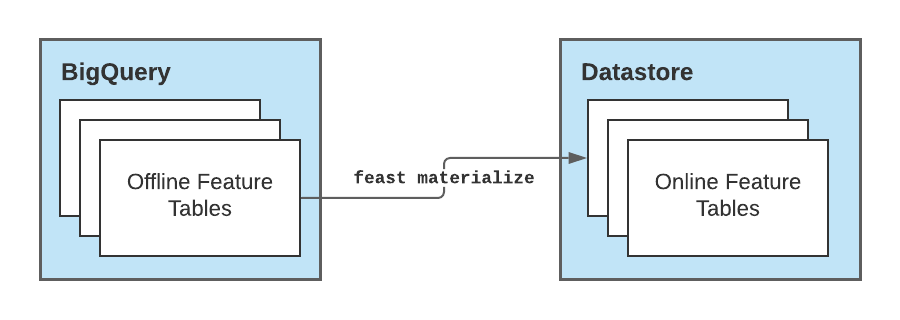

In [ ]:
!feast materialize-incremental $(date -u +"%Y-%m-%dT%H:%M:%S")

# Low latency inference

To make a prediction in real-time, we need to do the following:

1. Fetch our features using the Feast client
2. Pass these features to our AI Platform endpoint
3. Return these predictions to the user

![Feast landing page, blog post - [Archive].png](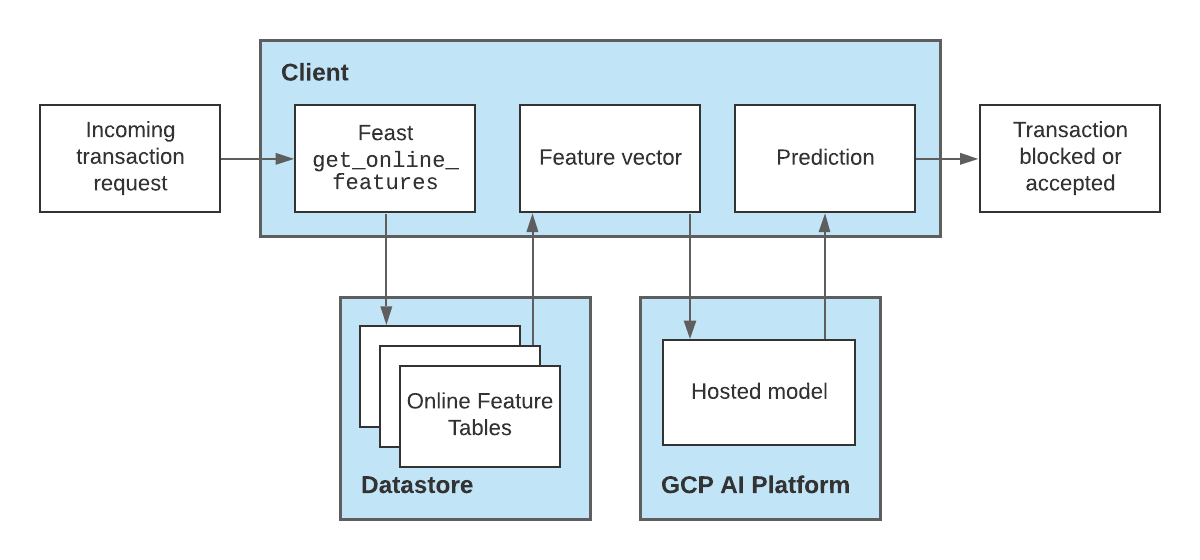)


In [ ]:
def predict(entity_rows):
    feature_vector = store.get_online_features(
        feature_refs=[
        "user_transaction_count_7d:transaction_count_7d",
        "user_account_features:credit_score",
        "user_account_features:account_age_days",
        "user_account_features:user_has_2fa_installed",
        "user_has_fraudulent_transactions:user_has_fraudulent_transactions_7d"
    ],
        entity_rows=entity_rows
    ).to_dict()
    
    # Delete entity keys
    del feature_vector["user_id"]

    # Flatten response from Feast
    instances = [[feature_values[0] for feature_values in feature_vector.values()]]
    
    service = googleapiclient.discovery.build('ml', 'v1')
    name = f'projects/{PROJECT_ID}/models/{AI_PLATFORM_MODEL_NAME}'
    
    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()
    
    clear_output()
    return response

predict([{"user_id": "v5zlw0"}])

{'predictions': [2.4773603480992787]}

This code is ready to be used in a production Python application. If your application can't access Python, you have two options:

1. You can move the entire `predict()` function into a Cloud Function.
2. You can move the `store.get_online_features` call into the AI Platform endpoint using a Custom Prediction Routine.

# Scheduling Updates

We now have a model that's running in production, but several steps of the workflow were ran manually. Specifically:

1. We ran a SQL query to update our feature values
2. We materialized features to the online store 

For our setup to be prodution ready, we need to schedule a workflow for these actions to occur on a regular basis. Let's do that using a Cloud Function and a Cloud Scheduler job:

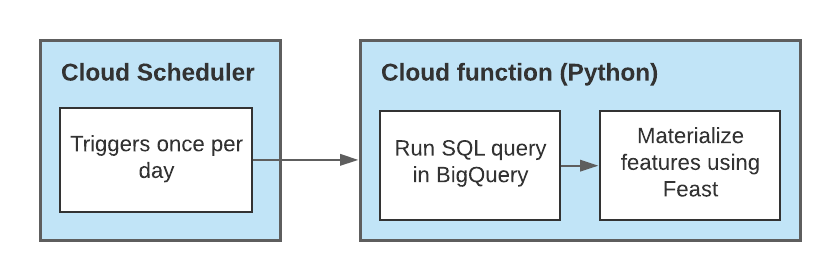

## Create a cloud function

In [ ]:
!mkdir cloud_function

In [ ]:
configs = f"""
project_id = '{PROJECT_ID}'
bigquery_dataset_name = '{BIGQUERY_DATASET_NAME}'
bucket_name = '{BUCKET_NAME}'
"""

with open('cloud_function/configs.py', "w") as configs_file:
    configs_file.write(configs)

In [ ]:
%%writefile cloud_function/main.py
from datetime import datetime, timedelta
from google.cloud import bigquery
from feast import FeatureStore, RepoConfig
from configs import project_id, bigquery_dataset_name, bucket_name


def generate_user_count_features(aggregation_end_date):
    table_id  = f"{project_id}.{bigquery_dataset_name}.user_count_transactions_7d"

    client = bigquery.Client()
    job_config = bigquery.QueryJobConfig(destination=table_id, write_disposition='WRITE_APPEND')

    aggregation_start_date = datetime.now() - timedelta(days=7)

    sql = f"""
    SELECT
        src_account AS user_id,
        COUNT(*) AS transaction_count_7d,
        timestamp'{aggregation_end_date.isoformat()}' AS feature_timestamp
    FROM
        feast-oss.fraud_tutorial.transactions
    WHERE
        timestamp BETWEEN TIMESTAMP('{aggregation_start_date.isoformat()}')
        AND TIMESTAMP('{aggregation_end_date.isoformat()}')
    GROUP BY
        user_id
    """

    query_job = client.query(sql, job_config=job_config)
    query_job.result()
    print("Generated features as of: ", aggregation_end_date.isoformat())


def materialize_features(end_date):
    store = FeatureStore(
        config=RepoConfig(
            project="fraud_tutorial",
            registry=f"gs://{bucket_name}/registry.db",
            provider="gcp"
        )
    )
    store.materialize_incremental(end_date=datetime.now())

def main(data, context):
    generate_user_count_features(aggregation_end_date=datetime.now())
    materialize_features(end_date=datetime.now())

Writing cloud_function/main.py


In [ ]:
%%writefile cloud_function/requirements.txt
google-cloud-bigquery
feast[gcp]

Writing cloud_function/requirements.txt


In [ ]:
!cd cloud_function && gcloud functions deploy feast-update-features \
--entry-point main \
--runtime python37 \
--trigger-resource feast-schedule \
--trigger-event google.pubsub.topic.publish \
--timeout 540s


For Cloud Build Logs, visit: https://console.cloud.google.com/cloud-build/builds;region=us-central1/88d22767-90f6-4c14-a2fb-1f4541f7aaed?project=883187091528
availableMemoryMb: 256
buildId: 3af6d12a-aa48-4464-9992-f721a05676c9
entryPoint: main
eventTrigger:
  eventType: google.pubsub.topic.publish
  failurePolicy: {}
  resource: projects/kf-feast/topics/feast-schedule
  service: pubsub.googleapis.com
ingressSettings: ALLOW_ALL
labels:
  deployment-tool: cli-gcloud
name: projects/kf-feast/locations/us-central1/functions/feast-update-features
runtime: python37
serviceAccountEmail: kf-feast@appspot.gserviceaccount.com
sourceUploadUrl: https://storage.googleapis.com/gcf-upload-us-central1-b3c947c0-762d-42fb-b26f-96cd83cc3dfb/08c72bc1-fbb7-44ee-adb6-ef185c3c2f8c.zip?GoogleAccessId=service-883187091528@gcf-admin-robot.iam.gserviceaccount.com&Expires=1627168941&Signature=fw3gdJAs9sn50tZc78eo63sqkHWcr1SogH7LrUdfFV05PWcqzffN0MCjkCCIqjgeTTOxze4KiZRzhqAdY0mPYZrrfJWk%2Fh6SEuZJ66gN0fKQp50j3wMJstuQ

## Schedule the cloud function


In [ ]:
!gcloud scheduler jobs create pubsub feast-daily-job \
--schedule "0 22 * * *" \
--topic feast-schedule \
--message-body "This job schedules feature materialization once a day."

## [Optional] Configure BigQuery permissions

You might also need to give your cloud function permission to access your BigQuery dataset. To do this:

1. Open your dataset in BigQuery.
2. Hover over the plus icon, and click "share dataset."
3. In the pop-up, enter your project's service account email. This should be `[PROJECT_ID]@appspot.gserviceaccount.com`. 
4. Select permission "Can Edit" and confirm.

## Run the workflow

If you want to test the workflow interactively:

1. Open the Cloud Scheduler page in the console.
2. Click the ‘Run Now’ button in the feast-daily-job row.
3. Open the Cloud Function page in the console.
4. Open your Cloud Function (feast-update-features.)
5. Open the Logs tab to see the latest run of your cloud function.

# Next steps

We have just built an end-to-end system using Feast and GCP. This system generates realtime predictions using up to date feature values from our model.

Next steps that you can take after completing this tutorial include:

- Check your repo into git to enable collaboration with your team.
- Use this tutorial to bootstrap a model for your use case by editing features / model.
- Incorporate the code in this tutorial into your company's batch pipelines by creating stages that perform feature creation and materialization.

# Cleanup

If you want to clean up the resources created during this tutorial, run the following cells:


In [ ]:
!bq rm -t -f feast_fraud_tutorial.user_count_transactions_7d
!bq rm -r -f -d feast_fraud_tutorial
!gcloud functions delete feast-update-features
!gcloud scheduler jobs delete feast-daily-job --project $PROJECT_ID

Resource [projects/kf-feast/locations/us-central1/functions/feast-upda
te-features] will be deleted.

Do you want to continue (Y/n)?  Y

Deleted [projects/kf-feast/locations/us-central1/functions/feast-update-features].
You are about to delete job [feast-daily-job]

Do you want to continue (Y/n)?  Y

Deleted job [feast-daily-job].
